In this informal notebook, we start the study of a problem related to the training of Neural Networks (abbr. NN). We skip now
any formal definition and just fix some common language.
We use a simple 4-layer network with
a total of 23 parameters and a logistic activation function.

In the real world practice the parameters are million, but it's better to start soft.

A set of 10 labelled points (here omitted) had been generated on the unit square,
and the task is to train the network accoring to them.

In other words, we want to minimize the error function 
$U:  \mathbb{R}^{23} \to [0,1]$ here also
called "energy function". Instead, the domain has been restricted to
a $23$-dim hypercube $[-20, 20]^{23}$ for simplicity
(we omit details on purpose). Just to clarify, we stress that the
domain's dimension, $23$, equals the number of parameters of the model.

The minimization of $U$ can be successfully done by using (stochastic)
gradient techniques, but we ask for something different: what about the
geometry of such a "landscape"? 

Our goal is therefore not only to minimize the error function $U$, but
rather to understand its geometry with the hope of gaining some
intuition concerning general training for NN.

We generated a list of 9999 samples covering such a 23-dimensional space by using a suitable Monte Carlo method whose convergence
has been previously and independently verified.


A quick question comes: what if we tried easy, with a PCA 
decomposition on such a set of samples?
We do not expect anything in particular, it's for the sake of experimenting.

In [1]:
import numpy as np
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, KernelPCA

# Read the sample file
samples_file = open("nn_MULTI_chain.smp", "r")
# the first line can be ignored, is for debug
info_str = samples_file.readline()
X = []
for x in samples_file:
    X.append(np.array(x[0:-1].split(' ')).astype("float64"))
X = np.asanyarray(X)
X.shape
# Should give: 9999 samples, each of dimension 23

(9999, 23)

In [2]:
# Let's start with the classic naive _linear_ PCA
pca = PCA(n_components=3)
pca.fit(X)
pca.explained_variance_ratio_
sum(pca.explained_variance_ratio_)

0.31921579202061634

We note that the variances sum up to 0.3, a low value when compared to the optimal ~1.0.
It means that the 23D space cannot be so easily reduced to a 3D one.
But, for the sake of curiosity, we plot the reduced space anyway:

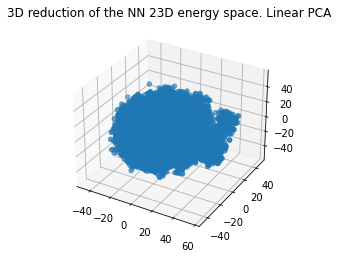

In [3]:
# Plotting the resulting 3D space coming from a linear
# PCA decomposition. Not informative.
reducedX = pca.transform(X)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(reducedX[:,0], reducedX[:,1], reducedX[:,2])
plt.title("3D reduction of the NN 23D energy space. Linear PCA")
plt.show()

As expected, this 3D reduction does not add any insight. Note that some points have coordinates outside the original $[20, 20]$ intervals, but it should something fine since we are considering their projections onto lower dimensional spaces (so they can be "distorted", but think more about that).

Let's see what happens if, instead of a linear PCA, we perform a kernelized variant.

In [4]:
# Let's try again with Kernelized PCA with a rbf (Gaussian) kernel
kpcaRBF = KernelPCA(n_components = 3, kernel = "rbf",
                    fit_inverse_transform=True, n_jobs = -1)
# NB: "fit_inverse_transform" will try later 
# to perform the inverse from 3D to 23D, generally impossible.
reducedXrbf = kpcaRBF.fit_transform(X)
# This time there is "explained variance" as in 
# the linear case seen before, so we plot directly the results

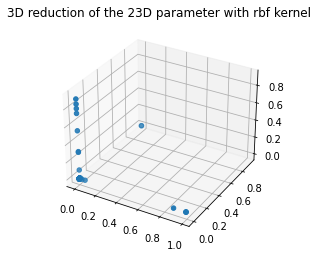

In [5]:
# Let's plot the reduced 3D space
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(reducedXrbf[:,0], reducedXrbf[:,1], reducedXrbf[:,2])
plt.title("3D reduction of the 23D parameter with rbf kernel")
plt.show()

It's honestly unexpected: the points seem to follow a very, very regular pattern.

It is not an easy task to "correctly" interpret these results, therefore we focus in a simple question: given the 3D representation, is it possible to go back to the 23D one? We expect a clear "no", but...never say never...

In order to analyze that fact, we compare the expectation of the original samples with the expectation of the inverted transformations.



In [6]:
# Expectation of the original dataset
expX = sum(X)/len(X)
# Expectation of the reconstructed dataset
reconstructedX = kpcaRBF.inverse_transform(reducedXrbf)
expRBF = sum(reconstructedX) / len(reconstructedX)
# Computing their difference
from numpy.linalg import norm
print("Expectation difference: ", norm(expRBF - expX))
print("Point-by-point difference: ", norm(X - reconstructedX))

Expectation difference:  1.7511272934818215e-12
Point-by-point difference:  4.684466263748598e-10


That's...seriously unexpected. Completely. We see that: despite reducing the space from dimension 23 to dimension 3, the original samples can still be 100% reconstructed!!!

Remark: we also tried with other kind of kernels, but with no comparable results. 
Only rbf seems to work, and to work incredibly well...

Now, a (many...) question arises: is the way in which the points are arranged related to their energy value?
Recall that we are interested in very low energy points, since they train the network well.
Let's label and print the point between an energy band, as described below.

In [7]:
# Import the energy function from my other python scripts
import nn_potential
def U(x):
    b2, b3, b4, W2, W3, W4 = nn_potential.split_params(x)
    return nn_potential.total_cost(nn_potential.x,
            nn_potential.y, b2, b3, b4, W2, W3, W4, 10)

In [8]:
# Now, let's LABEL these 3 dimensional points:
# 1 if their energy is between some level, 0 otherwise
# (we want to avoid too low levels, since it means overfitting)
max_energy = 0.001
min_energy = 0.0001
labels = np.zeros(len(reducedXrbf))
for i in range(len(reconstructedX)):
    Ui = U(reconstructedX[i])
    if Ui < max_energy and Ui > min_energy:
        labels[i] = 1

Amout of low energy points:  346
...of not-so-low:  9653


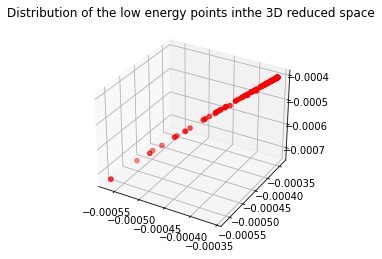

In [9]:
# Subdivide the points into two classes, then print each of them
lowX, highX = [], []
for i in range(len(labels)):
    if labels[i]:
        lowX.append(reducedXrbf[i])
    else:
        highX.append(reducedXrbf[i])
print("Amout of low energy points: ", len(lowX))
print("...of not-so-low: ", len(highX))

# Convert the points into a numpy array
lowX = np.asanyarray(lowX)
highX = np.asanyarray(highX)

# Plot, in 3D, only the points with right energy
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(lowX[:,0], lowX[:,1], lowX[:,2], color='red')
plt.title("Distribution of the low energy points in" +\
          "the 3D reduced space")
plt.show()

It seems that all the very low energy points are located in a 1-dimensional manifold. Again, unexpected.
Let's try confirm the intuition, by using PCN again...

In [10]:
# Perform a classic PCA reduction on the low-energy space,
# which seem to be located on a line...
pcaLOW = PCA(n_components=1)
pcaLOW.fit(lowX)
pcaLOW.explained_variance_ratio_
sum(pcaLOW.explained_variance_ratio_)

0.9997610828303326

Having a value of 0.99 (basically 1.0) means that the PCA decomposition performed very, very well!
But can the original 3D points be safely reconstructed by using only
this 1D line?

In [11]:
minimumX = pcaLOW.transform(lowX)
norm(minimumX - pcaLOW.inverse_transform(minimumX))

0.012993270427499409

The error is reasonabily low...therefore the answer is a "yes".

CONCLUSION

We started with the problem of studying the geometry of the energy space for a simple Neural Network with 23 parameters (formally defined elsewere). The main issue was to locate points with low energy, since they train the network well. The space is in principle vey complicated, but a kernelized PCA has shown that it can be reduced to a simple 3D space, where the low energy points are all located among a line.
All the dimension-reduction involved are surprisingly reversible...



QUESTION: what does is precisely mean? Is it possible that the procedure of training a Neural Network can be performed on a very, very low dimensional space (1,2 or 3 dim) allowing huge performance improvements? And why does the rbf kernel work so well?
